In [1]:
import azure_storage_config
import azure.common
from azure.storage import CloudStorageAccount
from tablestorageaccount import TableStorageAccount
import pandas as pd


In [3]:
# Create the storage account object and specify its credentials 
account_connection_string = azure_storage_config.STORAGE_CONNECTION_STRING

# Split into key=value pairs removing empties, then split the pairs into a dict
config = dict(s.split('=', 1) for s in account_connection_string.split(';') if s)

# Authentication
account_name = config.get('AccountName')
account_key = config.get('AccountKey')
print("AccountName: " + account_name)
# Basic URL Configuration
endpoint_suffix = config.get('EndpointSuffix')

if endpoint_suffix == None:
    table_endpoint  = config.get('TableEndpoint')
    table_prefix = '.table.'
    start_index = table_endpoint.find(table_prefix)
    end_index = table_endpoint.endswith(':') and len(table_endpoint) or table_endpoint.rfind(':')
    endpoint_suffix = table_endpoint[start_index+len(table_prefix):end_index]

account = TableStorageAccount(account_name = account_name, connection_string = account_connection_string, endpoint_suffix=endpoint_suffix)


An: oapstorageprod


In [4]:
table_service = account.create_table_service()

In [5]:
###Downloads all the entities from the table storage
def get_prediction_entities(filter_expression):
    i=0
    next_marker = None
    entities = pd.DataFrame()


    while True:
        tmp_entities = table_service.query_entities("forecastsuswestv1", filter=filter_expression,  marker=next_marker)
        i+=1
        entities = pd.concat([entities, pd.DataFrame(tmp_entities.items)])
        next_marker = tmp_entities.next_marker
        #print(str(len(entities_above)))
        if(len(next_marker) == 0):
            break;
    return entities
    
    

In [6]:
above_filter = "ModelName eq 'DangerAboveTreelineV1NW'"
entities_above = get_prediction_entities(above_filter)

In [7]:
near_filter = "ModelName eq 'DangerNearTreelineV1NW'"
entities_near = get_prediction_entities(near_filter)

below_filter = "ModelName eq 'DangerBelowTreelineV1NW'"
entities_below = get_prediction_entities(below_filter)

In [8]:
entities_above['Elevation'] = 'PredictedDangerAbove'

In [9]:
entities_near['Elevation'] = 'PredictedDangerNear'
entities_below['Elevation'] = 'PredictedDangerBelow'

In [10]:
entities = pd.concat([entities_above, entities_near, entities_below])

In [11]:
#expand rowkey to lat, lon
entities = pd.concat([entities, entities['RowKey'].str.split(':', expand=True)], axis=1)

In [12]:
entities.columns = ['Date', 'ModelName', 'PartitionKey','Prediction', 'PredictionValue', 'RegionName','RowKey','Timestamp','etag','Elevation','Lat','Lon']

In [13]:
entities = entities[['Date', 'Prediction', 'Elevation', 'Lat', 'Lon']]

In [14]:
entities.head()

,Date,Prediction,Elevation,Lat,Lon
0,2018-02-01 00:00:00+00:00,Moderate,PredictedDangerAbove,42.00039,-124.1694
1,2018-02-01 00:00:00+00:00,Low,PredictedDangerAbove,42.00375,-118.2896
2,2018-02-01 00:00:00+00:00,Low,PredictedDangerAbove,42.0064,-119.8632
3,2018-02-01 00:00:00+00:00,Low,PredictedDangerAbove,42.00845,-123.4518
4,2018-02-01 00:00:00+00:00,Low,PredictedDangerAbove,42.01232,-124.7495


In [15]:
#assign a row to a region
def add_location(row):
    if(row['Lat'] > 47.494090 and row['Lat'] < 48.060641 and row['Lon'] > -123.991862 and row['Lon'] < -122.960095):
        row['Region'] = 'Olympics'
    elif(row['Lat'] > 47.212958 and row['Lat'] < 47.473511 and row['Lon'] > -121.555157 and row['Lon'] < -121.257812):
        row['Region'] = 'Cascade Pass - Snoq. Pass'
    elif(row['Lat'] > 47.701877 and row['Lat'] < 47.797360 and row['Lon'] > -121.181196 and row['Lon'] < -121.041215):
        row['Region'] = 'Cascade Pass - Stevens Pass'
    elif(row['Lat'] > 48.510484 and row['Lat'] < 48.995711 and row['Lon'] > -121.912707 and row['Lon'] < -120.746659):
        row['Region'] = 'Cascade West - North'
    elif(row['Lat'] > 48.248491 and row['Lat'] < 49.001051 and row['Lon'] > -120.725360 and row['Lon'] < -120.003778):
        row['Region'] = 'Cascade East - North'
    elif(row['Lat'] > 47.818808 and row['Lat'] < 48.547969 and row['Lon'] > -121.285539 and row['Lon'] < -120.791154):
        row['Region'] = 'Cascade West - Central'
    elif(row['Lat'] > 47.299076 and row['Lat'] < 48.147311 and row['Lon'] > -120.982659 and row['Lon'] < -120.385882):
        row['Region'] = 'Cascade East - Central'
    elif(row['Lat'] > 45.781421 and row['Lat'] < 47.077239 and row['Lon'] > -122.010501 and row['Lon'] < -121.526113):
        row['Region'] = 'Cascade West - South'
    elif(row['Lat'] > 46.022933 and row['Lat'] < 47.082326 and row['Lon'] > -121.643447 and row['Lon'] < -121.071664):
        row['Region'] = 'Cascade East - South'
    elif(row['Lat'] > 45.267472 and row['Lat'] < 45.505084 and row['Lon'] > -121.894018 and row['Lon'] < -121.599378):
        row['Region'] = 'Mt Hood'
    return row
    


In [16]:
entities[['Lat', 'Lon']] = entities[['Lat', 'Lon']].apply(pd.to_numeric)

In [17]:
entities = entities.apply(add_location, axis=1)

In [18]:
entities['Elevation'].value_counts()

PredictedDangerBelow    261521
PredictedDangerNear     261521
PredictedDangerAbove    261521
Name: Elevation, dtype: int64

In [19]:
entities['Region'].value_counts()

Olympics                       9480
Cascade West - South           8694
Cascade West - North           7236
Cascade East - South           7233
Cascade East - North           7038
Cascade East - Central         6900
Cascade West - Central         4353
Mt Hood                         948
Cascade Pass - Snoq. Pass       948
Cascade Pass - Stevens Pass     180
Name: Region, dtype: int64

In [20]:
entities = entities.dropna(axis=0)

In [21]:
entities.head()

,Date,Elevation,Lat,Lon,Prediction,Region
351,2018-02-01 00:00:00+00:00,PredictedDangerAbove,45.32503,-121.7681,Low,Mt Hood
360,2018-02-01 00:00:00+00:00,PredictedDangerAbove,45.34506,-121.6253,Low,Mt Hood
401,2018-02-01 00:00:00+00:00,PredictedDangerAbove,45.42537,-121.7967,Low,Mt Hood
409,2018-02-01 00:00:00+00:00,PredictedDangerAbove,45.44541,-121.6538,Low,Mt Hood
590,2018-02-01 00:00:00+00:00,PredictedDangerAbove,45.82596,-121.9117,Low,Cascade West - South


In [22]:
tmp = entities.copy()

In [23]:
tmp.set_index(['Date', 'Region', 'Lat', 'Lon', 'Elevation'], inplace=True)

In [24]:
tmp.head()

Prediction
Date                      Region               Lat      Lon       Elevation                      
2018-02-01 00:00:00+00:00 Mt Hood              45.32503 -121.7681 PredictedDangerAbove        Low
                                               45.34506 -121.6253 PredictedDangerAbove        Low
                                               45.42537 -121.7967 PredictedDangerAbove        Low
                                               45.44541 -121.6538 PredictedDangerAbove        Low
                          Cascade West - South 45.82596 -121.9117 PredictedDangerAbove        Low

In [25]:
#flatten the pivot table
tmp = tmp.unstack(level=-1)

In [26]:
tmp.head()

Prediction  \
Elevation                                                           PredictedDangerAbove   
Date                      Region                 Lat      Lon                              
2018-02-01 00:00:00+00:00 Cascade East - Central 47.31560 -120.8349             Moderate   
                                                 47.33464 -120.6888                  Low   
                                                 47.35358 -120.5427                  Low   
                                                 47.37240 -120.3965                  Low   
                                                 47.41457 -120.8631         Considerable   

                                                                                          \
Elevation                                                           PredictedDangerBelow   
Date                      Region                 Lat      Lon                              
2018-02-01 00:00:00+00:00 Cascade East - Central 47.31560 -120.8349                  Low   
                                                 47.33464 -120.6888                  Low   
                                                 47.35358 -120.5427                  Low   
                                                 47.37240 -120.3965                  Low   
                                                 47.41457 -120.8631                  Low   

                                                                                         
Elevation                                                           PredictedDangerNear  
Date                      Region                 Lat      Lon                            
2018-02-01 00:00:00+00:00 Cascade East - Central 47.31560 -120.8349            Moderate  
                                                 47.33464 -120.6888            Moderate  
                                                 47.35358 -120.5427                 Low  
                                                 47.37240 -120.3965                 Low  
                                                 47.41457 -120.8631            Moderate

In [27]:
tmp.reset_index(inplace=True)

In [30]:
nwac_forecasts = pd.read_csv('../Data/CleanedForecastsNWAC.V2.csv', low_memory=False)

In [31]:
nwac_forecasts.columns

Index(['Region', 'PublishedDateTime', 'Day1Date', 'SpecialStatement',
       'BottomLineSummary', 'ForecastUrl', 'Day1DangerAboveTreeline',
       'Day1DangerNearTreeline', 'Day1DangerBelowTreeline',
       'Day1DetailedForecast',
       ...
       'WindSlab_OctagonNearTreelineSouthWest',
       'WindSlab_OctagonNearTreelineWest', 'WindSlab_OctagonBelowTreelineEast',
       'WindSlab_OctagonBelowTreelineNorth',
       'WindSlab_OctagonBelowTreelineNorthEast',
       'WindSlab_OctagonBelowTreelineNorthWest',
       'WindSlab_OctagonBelowTreelineSouth',
       'WindSlab_OctagonBelowTreelineSouthEast',
       'WindSlab_OctagonBelowTreelineSouthWest',
       'WindSlab_OctagonBelowTreelineWest'],
      dtype='object', length=263)

In [32]:
nwac_forecasts['Day1Date'] = pd.to_datetime(nwac_forecasts['Day1Date'], format='%Y%m%d', utc=True)

In [33]:
#filter out special avalanche statements which we aren't predicting
nwac_forecasts = nwac_forecasts[nwac_forecasts['Day1DangerAboveTreeline'].isin(['Low', 'Moderate', 'Considerable', 'High'])]

In [34]:
nwac_forecasts = nwac_forecasts[['Region', 'Day1Date', 'Day1DangerAboveTreeline', 'Day1DangerNearTreeline', 'Day1DangerBelowTreeline']]

In [35]:
nwac_forecasts.head()

,Region,Day1Date,Day1DangerAboveTreeline,Day1DangerNearTreeline,Day1DangerBelowTreeline
0,Olympics,2013-12-11 00:00:00+00:00,Moderate,Moderate,Low
1,Cascade Pass - Stevens Pass,2013-12-11 00:00:00+00:00,Moderate,Moderate,Low
2,Cascade Pass - Snoq. Pass,2013-12-11 00:00:00+00:00,Moderate,Moderate,Low
3,Mt Hood,2013-12-11 00:00:00+00:00,Moderate,Moderate,Low
4,Cascade West - Stevens Pass N,2013-12-11 00:00:00+00:00,Moderate,Moderate,Low


In [36]:
tmp.columns = ['Date', 'Region', 'Lat', 'Lon', 'PredictedDangerAbove', 'PredictedDangerBelow', 'PredictedDangerNear']

In [37]:
tmp.shape

(17670, 7)

In [39]:
merged_df = tmp.merge(nwac_forecasts, how='inner', left_on=['Date', 'Region'], right_on=['Day1Date', 'Region'])

In [42]:
merged_df[~merged_df['Day1DangerAboveTreeline'].isin(['Low', 'Moderate', 'Considerable', 'High'])].head()

,Date,Region,Lat,Lon,PredictedDangerAbove,PredictedDangerBelow,PredictedDangerNear,Day1Date,Day1DangerAboveTreeline,Day1DangerNearTreeline,Day1DangerBelowTreeline


In [43]:
merged_df.head()

,Date,Region,Lat,Lon,PredictedDangerAbove,PredictedDangerBelow,PredictedDangerNear,Day1Date,Day1DangerAboveTreeline,Day1DangerNearTreeline,Day1DangerBelowTreeline
0,2018-02-01 00:00:00+00:00,Cascade East - Central,47.31560,-120.8349,Moderate,Low,Moderate,2018-02-01 00:00:00+00:00,Moderate,Moderate,Low
1,2018-02-01 00:00:00+00:00,Cascade East - Central,47.33464,-120.6888,Low,Low,Moderate,2018-02-01 00:00:00+00:00,Moderate,Moderate,Low
2,2018-02-01 00:00:00+00:00,Cascade East - Central,47.35358,-120.5427,Low,Low,Low,2018-02-01 00:00:00+00:00,Moderate,Moderate,Low
3,2018-02-01 00:00:00+00:00,Cascade East - Central,47.37240,-120.3965,Low,Low,Low,2018-02-01 00:00:00+00:00,Moderate,Moderate,Low
4,2018-02-01 00:00:00+00:00,Cascade East - Central,47.41457,-120.8631,Considerable,Low,Moderate,2018-02-01 00:00:00+00:00,Moderate,Moderate,Low


In [44]:
def set_critical_points(row):
    #Olympics: Hurricane Ridge: -123.4724, 47.98101
    #West North: Mt Baker Ski Area: 48.837311, -121.648575
    #West Central: Between Mt Loop and Glacier Peak: -121.2094, 48.08577
    #West South: Paradise: -121.7392, 46.78271
    #Snoqualmie Pass: Alpental: -121.47762, 47.43613
    #Stevens Pass: Stevens Pass North: -121.1233, 47.79041
    #East North: Cutthroat peak/Washington Pass: -120.7334, 48.55459
    #East Central: Enchantments:  -120.8913, 47.51345
    #East South: Mt Adams: -121.5665, 46.18549
    #Mt Hood: Government Camp: -121.7681, 45.32503
    if(row['Lat'] == 47.98101 and row['Lon'] == -123.4724):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 43.83084 and row['Lon'] == -121.7387):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 48.08577 and row['Lon'] == -121.2094):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 46.78271 and row['Lon'] == -121.7392):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 47.43613 and row['Lon'] == -121.47762):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 47.79041 and row['Lon'] == -121.1233):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 48.55459 and row['Lon'] == -120.7334):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 47.51345 and row['Lon'] == -120.8913):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 46.18549 and row['Lon'] == -121.5665):
        row['CriticalForecastPoint'] = True
    elif(row['Lat'] == 45.32503 and row['Lon'] == -121.7681):
        row['CriticalForecastPoint'] = True
    else:
        row['CriticalForecastPoint'] = False
    return row
    

In [45]:
merged_df = merged_df.apply(set_critical_points, axis=1)

In [46]:
merged_df['CriticalForecastPoint'].value_counts()

False    16418
True       300
Name: CriticalForecastPoint, dtype: int64

In [47]:
def label_to_value(cell):
    if(cell == 'Low'):
        return int(0)
    elif(cell == 'Moderate'):
        return int(1)
    elif(cell == 'Considerable'):
        return int(2)
    elif(cell == 'High'):
        return int(3)
    else:
        print(cell)
        return int(4)

In [49]:
oap_classification_reports.evaluateSingleClassShort( merged_df['Day1DangerAboveTreeline'].apply(label_to_value), merged_df['PredictedDangerAbove'].apply(label_to_value))


Accuracy: 0.22508673286278263
Classification Report
             precision    recall  f1-score   support

          0       0.08      0.59      0.14      1332
          1       0.38      0.22      0.28      7959
          2       0.50      0.17      0.25      6683
          3       0.45      0.14      0.22       744

avg / total       0.41      0.23      0.25     16718



In [64]:
#TODO: refactor this to a shared method
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Normalizer

def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test, result))

#nice confustion matrix plot taken from scikit-learn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

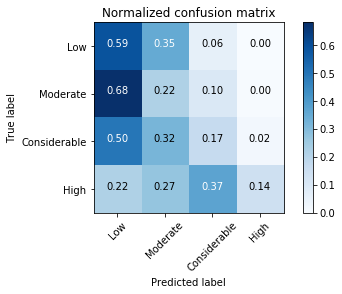

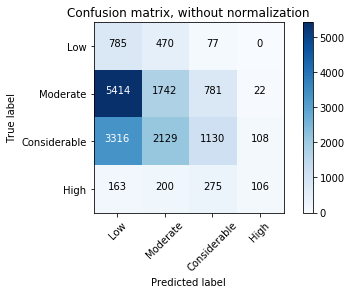

In [67]:

cnf_matrix = confusion_matrix(merged_df['Day1DangerAboveTreeline'].apply(label_to_value), merged_df['PredictedDangerAbove'].apply(label_to_value))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Confusion matrix, without normalization')
plt.show()

In [52]:
oap_classification_reports.evaluateSingleClassShort( merged_df['Day1DangerNearTreeline'].apply(label_to_value), merged_df['PredictedDangerNear'].apply(label_to_value))


Accuracy: 0.3205526976911114
Classification Report
             precision    recall  f1-score   support

          0       0.13      0.54      0.21      1939
          1       0.51      0.45      0.48      9143
          2       0.48      0.02      0.04      5146
          3       0.37      0.18      0.24       490

avg / total       0.45      0.32      0.30     16718



In [53]:
oap_classification_reports.evaluateSingleClassShort( merged_df['Day1DangerBelowTreeline'].apply(label_to_value), merged_df['PredictedDangerBelow'].apply(label_to_value))


Accuracy: 0.27246082067232924
Classification Report
             precision    recall  f1-score   support

          0       0.27      0.91      0.42      4496
          1       0.30      0.05      0.08      8629
          2       0.29      0.01      0.02      3312
          3       0.00      0.00      0.00       281

avg / total       0.28      0.27      0.16     16718



C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
merged_df[merged_df['CriticalForecastPoint']==True]

,Date,Region,Lat,Lon,PredictedDangerAbove,PredictedDangerBelow,PredictedDangerNear,Day1Date,Day1DangerAboveTreeline,Day1DangerNearTreeline,Day1DangerBelowTreeline,CriticalForecastPoint
8,2018-02-01 00:00:00+00:00,Cascade East - Central,47.51345,-120.8913,Considerable,Low,Moderate,2018-02-01 00:00:00+00:00,Moderate,Moderate,Low,True
122,2018-02-01 00:00:00+00:00,Cascade West - South,46.18549,-121.5665,Considerable,Low,Moderate,2018-02-01 00:00:00+00:00,Considerable,Moderate,Moderate,True
146,2018-02-01 00:00:00+00:00,Mt Hood,45.32503,-121.7681,Low,Moderate,Moderate,2018-02-01 00:00:00+00:00,Moderate,Moderate,Moderate,True
183,2018-02-01 00:00:00+00:00,Olympics,47.98101,-123.4724,Considerable,Moderate,Moderate,2018-02-01 00:00:00+00:00,Moderate,Moderate,Moderate,True
198,2018-02-02 00:00:00+00:00,Cascade East - Central,47.51345,-120.8913,Considerable,Low,Moderate,2018-02-02 00:00:00+00:00,Considerable,Considerable,Moderate,True
312,2018-02-02 00:00:00+00:00,Cascade West - South,46.18549,-121.5665,Considerable,Low,Moderate,2018-02-02 00:00:00+00:00,Considerable,Considerable,Considerable,True
336,2018-02-02 00:00:00+00:00,Mt Hood,45.32503,-121.7681,Considerable,Moderate,Moderate,2018-02-02 00:00:00+00:00,Considerable,Moderate,Moderate,True
373,2018-02-02 00:00:00+00:00,Olympics,47.98101,-123.4724,Low,Moderate,Moderate,2018-02-02 00:00:00+00:00,Considerable,Moderate,Moderate,True
388,2018-02-03 00:00:00+00:00,Cascade East - Central,47.51345,-120.8913,Considerable,Moderate,Moderate,2018-02-03 00:00:00+00:00,Considerable,Moderate,Moderate,True
502,2018-02-03 00:00:00+00:00,Cascade West - South,46.18549,-121.5665,Low,Low,Moderate,2018-02-03 00:00:00+00:00,Considerable,Considerable,Considerable,True


In [56]:
oap_classification_reports.evaluateSingleClassShort( merged_df[merged_df['CriticalForecastPoint']==True]['Day1DangerAboveTreeline'].apply(label_to_value), merged_df[merged_df['CriticalForecastPoint']==True]['PredictedDangerAbove'].apply(label_to_value))


Accuracy: 0.27
Classification Report
             precision    recall  f1-score   support

          0       0.13      0.65      0.22        34
          1       0.39      0.22      0.28       140
          2       0.52      0.21      0.30       113
          3       0.80      0.31      0.44        13

avg / total       0.43      0.27      0.29       300



In [57]:
oap_classification_reports.evaluateSingleClassShort( merged_df['Day1DangerAboveTreeline'].apply(label_to_value), merged_df['PredictedDangerAbove'].apply(label_to_value))


Accuracy: 0.22508673286278263
Classification Report
             precision    recall  f1-score   support

          0       0.08      0.59      0.14      1332
          1       0.38      0.22      0.28      7959
          2       0.50      0.17      0.25      6683
          3       0.45      0.14      0.22       744

avg / total       0.41      0.23      0.25     16718

